In [13]:
from ai_assets import *

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array


def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test


def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_' +
                  group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_' +
                  group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_' +
                  group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group(
        'train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group(
        'test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ", trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

(470528, 9)


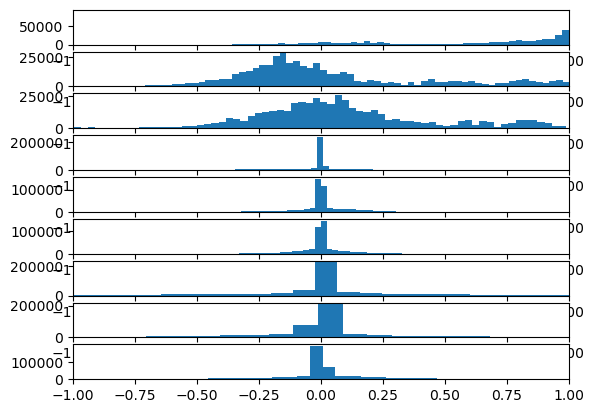

In [5]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

In [6]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [34]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()

# GRU 레이어 추가
model.add(GRU(units=100, input_shape=(
    n_timesteps, n_features), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=n_outputs, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 128, 100)          33300     
                                                                 
 dropout_1 (Dropout)         (None, 128, 100)          0         
                                                                 
 gru_6 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 56,406
Trainable params: 56,406
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [36]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size,
                    verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 19s 172ms/step - loss: 1.1995 - accuracy: 0.4816 - val_loss: 1.1172 - val_accuracy: 0.5710
Epoch 2/10
92/92 [==============================] - 15s 159ms/step - loss: 0.8321 - accuracy: 0.6494 - val_loss: 0.6038 - val_accuracy: 0.7872
Epoch 3/10
92/92 [==============================] - 15s 158ms/step - loss: 0.3754 - accuracy: 0.8631 - val_loss: 0.2653 - val_accuracy: 0.9191
Epoch 4/10
92/92 [==============================] - 16s 170ms/step - loss: 0.1898 - accuracy: 0.9361 - val_loss: 0.2244 - val_accuracy: 0.9313
Epoch 5/10
92/92 [==============================] - 15s 166ms/step - loss: 0.1688 - accuracy: 0.9424 - val_loss: 0.2650 - val_accuracy: 0.8967
Epoch 6/10
92/92 [==============================] - 15s 163ms/step - loss: 0.1541 - accuracy: 0.9441 - val_loss: 0.2597 - val_accuracy: 0.9123
Epoch 7/10
92/92 [==============================] - 15s 162ms/step - loss: 0.1422 - accuracy: 0.9471 - val_loss: 0.2200 - val_accuracy: 0.9184

Visualize the training process (loss) w.r.t train set and the validation set

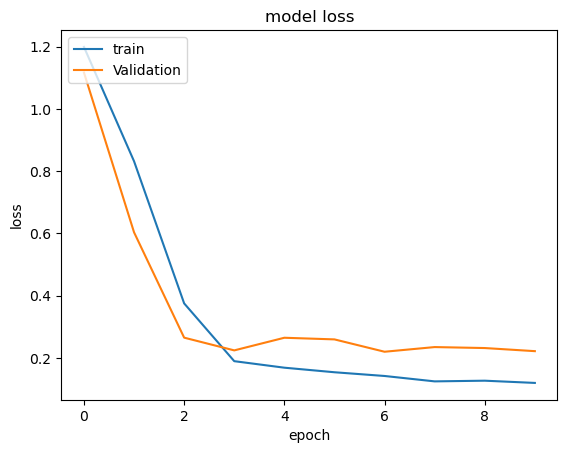

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [43]:
# evaluate model
test_loss, test_accuracy = model.evaluate(
    testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the GRU model 0.8897183537483215
93/93 [==============================] - 3s 36ms/step


In [39]:
predictions

array([[2.7509152e-03, 6.6875138e-05, 8.9041554e-05, 1.4639150e-02,
        9.8235714e-01, 9.6867218e-05],
       [2.2455582e-03, 5.3827105e-05, 8.2120227e-05, 1.5294235e-02,
        9.8223579e-01, 8.8547225e-05],
       [2.2368559e-03, 5.1785442e-05, 7.5990778e-05, 1.3504706e-02,
        9.8405153e-01, 7.9210229e-05],
       ...,
       [5.7698903e-04, 9.9852484e-01, 6.3478784e-04, 4.4538334e-07,
        4.1381994e-05, 2.2157698e-04],
       [5.6050747e-04, 9.9866498e-01, 4.7148965e-04, 3.6667979e-07,
        4.0121398e-05, 2.6252589e-04],
       [3.5811315e-04, 9.9893278e-01, 4.9540133e-04, 2.0959622e-07,
        1.0052117e-05, 2.0349580e-04]], dtype=float32)

In [40]:
from sklearn.metrics import classification_report

In [41]:
def display_results(testy, predictions, classNames):
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # /np.sum(cm[x,:])

    plt.figure(figsize=(10, 8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',
                     xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[436   6  52   1   1   0]
 [  9 438  24   0   0   0]
 [  3   1 416   0   0   0]
 [  2   2   0 423  64   0]
 [  3   0   0 138 391   0]
 [  0  19   0   0   0 518]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.88      0.92       496
           2       0.94      0.93      0.93       471
           3       0.85      0.99      0.91       420
           4       0.75      0.86      0.80       491
           5       0.86      0.73      0.79       532
           6       1.00      0.96      0.98       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



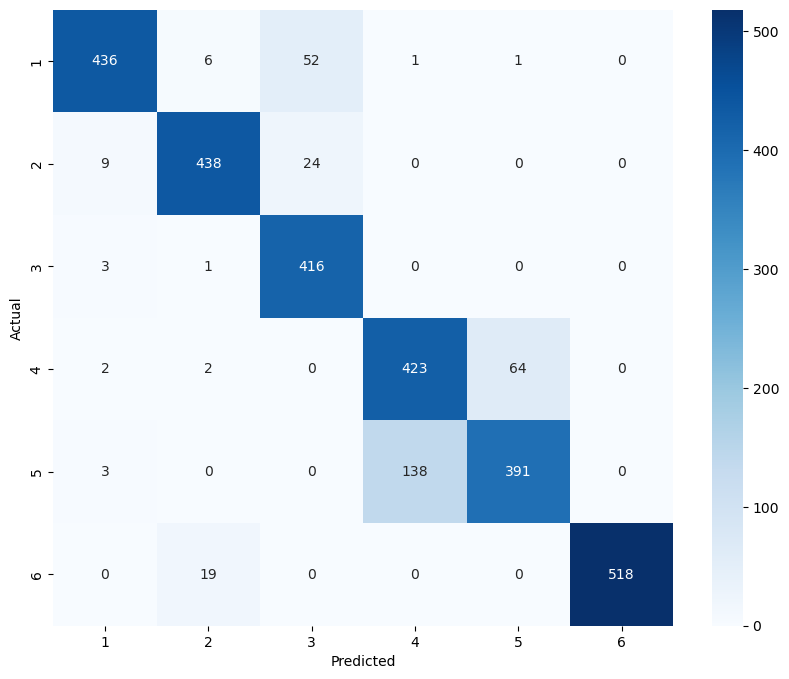

In [42]:
classNames = ["1", "2", "3", "4", "5", "6"]
display_results(testy, predictions, classNames)